# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

## Create Dataset with Four Class in a CSV File

In [4]:
np.random.seed(0)

def generate_class_data(center_x, center_y, size=250, spread=1.5):
    x1 = np.random.randn(size) * spread + center_x
    x2 = np.random.randn(size) * spread + center_y
    return x1, x2

# Generating data for each class
x1_top, x2_top = generate_class_data(3, 4)
x1_bottom, x2_bottom = generate_class_data(1, -6)
x1_left, x2_left = generate_class_data(-3, 2)
x1_right, x2_right = generate_class_data(5, 0)

# Labels
label_top = np.full(250, 0)
label_bottom = np.full(250, 1)
label_left = np.full(250, 2)
label_right = np.full(250, 3)

# Combining and making 2 features 
x1 = np.concatenate([x1_top, x1_bottom, x1_left, x1_right])
x2 = np.concatenate([x2_top, x2_bottom, x2_left, x2_right])
labels = np.concatenate([label_top, label_bottom, label_left, label_right])

# Saving to CSV
df = pd.DataFrame({'x1': x1, 'x2': x2, 'label': labels})
df.to_csv('four_class_dataset.csv', index=False)

print("CSV file 'four_class_dataset.csv' created.")


CSV file 'four_class_dataset.csv' created.


## Dataset Visualization

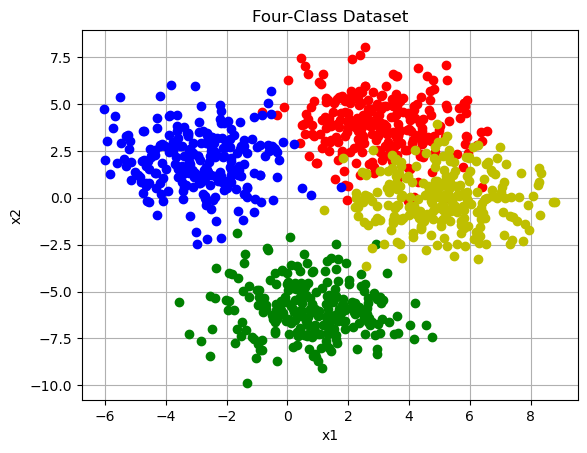

In [6]:
plt.figure()

for i in range(len(df)):
    if df['label'][i] == 0:
        plt.plot(df['x1'][i], df['x2'][i], "ro") #top class
    elif df['label'][i] == 1:
        plt.plot(df['x1'][i], df['x2'][i], "go") #bottom class
    elif df['label'][i] == 2:
        plt.plot(df['x1'][i], df['x2'][i], "bo") #left class
    else:
        plt.plot(df['x1'][i], df['x2'][i], "yo") #right class

plt.title("Four-Class Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()


## Features and Labels

In [8]:
df = pd.read_csv('four_class_dataset.csv')
X = df[['x1', 'x2']].values #features
Y = df[['label']].values #labels

encoder = OneHotEncoder(sparse_output=False) #using one hot encoding
Y = encoder.fit_transform(Y)

#80:20 train test split                         
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Neural Network
As the network performs multi-class classification, the number of output layer neurons is equal to the number of classes. The architecture includes three hidden layers, and the number of neurons in each can be adjusted. Additionally, the learning rate is configurable. Hidden layer 1 is directly connected to hidden layer 2, and hidden layer 2 is directly connected to hidden layer 3. Finally, the third hidden layer connects to the output layer. Weights for all connections are initialized randomly. The softmax function is used in the output layer, as it is suitable for multi-class classification problems.

In [10]:
class NeuralNetwork(object):
    def __init__(self, h1=30, h2=20, h3=10, lr=0.005):
        inputLayerNeurons = 2  #feature no: 2
        hiddenLayerNeurons1 = h1
        hiddenLayerNeurons2 = h2
        hiddenLayerNeurons3 = h3
        outputLayerNeurons = 4 #classes: 4

        print(f"Initialized with h1={h1}, h2={h2}, h3={h3}, lr={lr}")

        self.learning_rate = lr
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayerNeurons1)
        self.W_H2 = np.random.randn(hiddenLayerNeurons1, hiddenLayerNeurons2)
        self.W_H3 = np.random.randn(hiddenLayerNeurons2, hiddenLayerNeurons3)
        self.W_OH = np.random.randn(hiddenLayerNeurons3, outputLayerNeurons)

    #for hidden layers
    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1-x)

        else:
            return 1 / (1 + np.exp(-x))


    #for output layers
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        

    def feedForward(self, X):
        hidden_input1 = np.dot(X, self.W_H1)
        self.hidden_output1 = self.sigmoid(hidden_input1)

        hidden_input2 = np.dot(self.hidden_output1, self.W_H2)
        self.hidden_output2 = self.sigmoid(hidden_input2)

        hidden_input3 = np.dot(self.hidden_output2, self.W_H3)
        self.hidden_output3 = self.sigmoid(hidden_input3)

        output_input = np.dot(self.hidden_output3, self.W_OH)
        pred = self.softmax(output_input)
        return pred


    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error

        hidden_error3 = output_delta.dot(self.W_OH.T)
        hidden_delta3 = self.learning_rate * hidden_error3 * self.sigmoid(self.hidden_output3, der=True)

        hidden_error2 = hidden_delta3.dot(self.W_H3.T)
        hidden_delta2 = self.learning_rate * hidden_error2 * self.sigmoid(self.hidden_output2, der=True)

        hidden_error1 = hidden_delta2.dot(self.W_H2.T)
        hidden_delta1 = self.learning_rate * hidden_error1 * self.sigmoid(self.hidden_output1, der=True)

        self.W_H1 += X.T.dot(hidden_delta1)
        self.W_H2 += self.hidden_output1.T.dot(hidden_delta2)
        self.W_H3 += self.hidden_output2.T.dot(hidden_delta3)
        self.W_OH += self.hidden_output3.T.dot(output_delta)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)

## Loss

Initialized with h1=30, h2=20, h3=10, lr=0.005
Final Loss: 0.018383809498418387


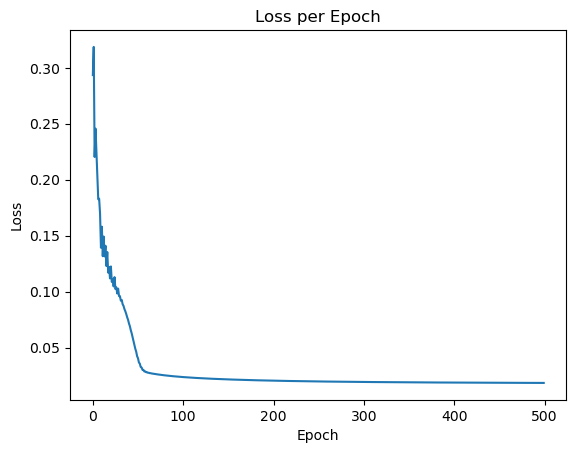

In [12]:
NN = NeuralNetwork()
err = []
for epoch in range(500):
    NN.train(X_train, Y_train)
    loss = np.mean(np.square(Y - NN.feedForward(X)))
    err.append(loss)
   
print(f"Final Loss: {err[-1]}")

plt.plot(err)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Predict and Evaluate

In [14]:
#predicted value
train_pred = np.argmax(NN.feedForward(X_train), axis=1)
test_pred = np.argmax(NN.feedForward(X_test), axis=1)

#actual value
Y_train_labels = np.argmax(Y_train, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

train_accuracy = accuracy_score(Y_train_labels, train_pred)
test_accuracy = accuracy_score(Y_test_labels, test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

print(f"nClassification Report(Test Data):")
print(classification_report(Y_test_labels, test_pred))

Training Accuracy: 0.95625
Testing Accuracy: 0.95
nClassification Report(Test Data):
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        44
           1       1.00      1.00      1.00        52
           2       1.00      0.96      0.98        55
           3       0.92      0.90      0.91        49

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



# Evaluation Matrix

## ROC AUC
The ROC curve illustrates the model’s ability to distinguish between classes across different thresholds, with a curve closer to the top-left indicating better performance. In this case, all four ROC curves overlapped when they reached a TPR of 1, indicating that all models eventually identified all true positives at some point.

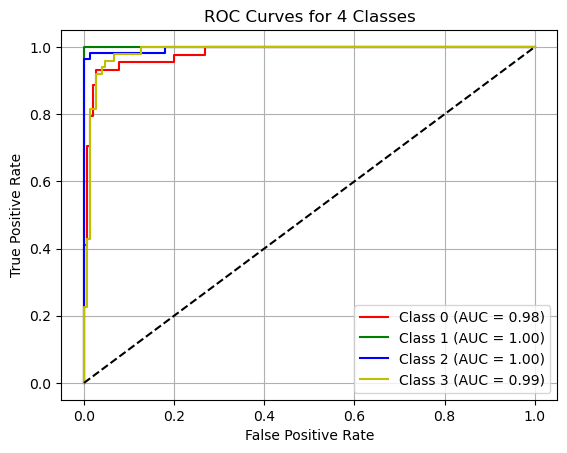

In [17]:
#Binarizing the true labels
y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Computing ROC curve and AUC for each class
fpr = {} #true positive rate
tpr = {} #false positive rate
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], th  = roc_curve(y_test_bin[:, i], NN.feedForward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plotting ROC curves
plt.figure()

for i in range(n_classes):
    if i == 0:
        plt.plot(fpr[i], tpr[i], "r-", label=f"Class 0 (AUC = {roc_auc[i]:.2f})")
    elif i == 1:
        plt.plot(fpr[i], tpr[i], "g-", label=f"Class 1 (AUC = {roc_auc[i]:.2f})")
    elif i == 2:
        plt.plot(fpr[i], tpr[i], "b-", label=f"Class 2 (AUC = {roc_auc[i]:.2f})")
    else:
        plt.plot(fpr[i], tpr[i], "y-", label=f"Class 3 (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.title("ROC Curves for 4 Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()


## Confusion Matrix
Confusion Matrix shows the count of true positives, true negatives, false positives, and false negatives, helping identify specific types of classification errors, such as misclassifying one class as another.

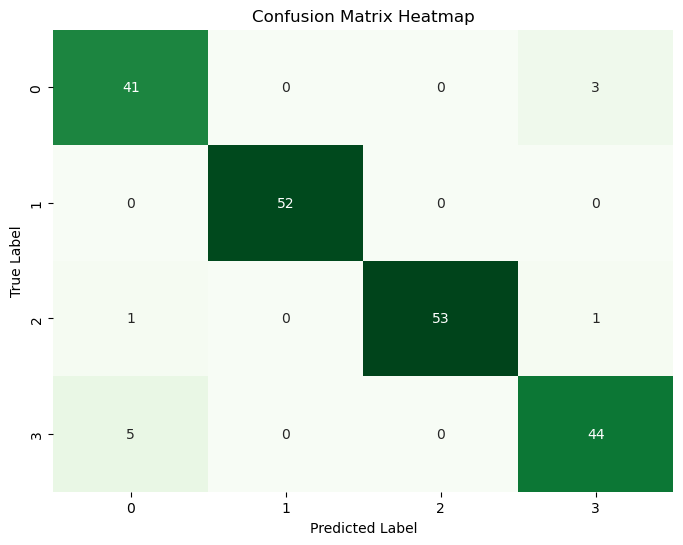

In [19]:
cm = confusion_matrix(Y_test_labels, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Comparison with Different Configuaration and hyperparameters

In [42]:
def train_network_for_epochs(model, X_train, Y_train, epochs=500):
    for epoch in range(epochs):
        model.train(X_train, Y_train)
        
#Same Network, higher learning rate
np.random.seed(0)
print("Same Network, Higher Learning Rate")
LR_high = NeuralNetwork(h1=30, h2=20, h3=10, lr=0.1)
train_network_for_epochs(LR_high, X_train, Y_train, epochs=500)
high_test_pred = np.argmax(LR_high.feedForward(X_test), axis=1)
print("Accuracy:", accuracy_score(Y_test_labels, high_test_pred))

# Same Network, Same Learning Rate
np.random.seed(0)
print("Same Network, Same Learning Rate")
NN_LR_same = NeuralNetwork(h1=10, h2=20, h3=20, lr=0.005)
train_network_for_epochs(NN_LR_same, X_train, Y_train, epochs=500)
same_test_pred = np.argmax(NN_LR_same.feedForward(X_test), axis=1)
print("Accuracy:", accuracy_score(Y_test_labels, same_test_pred))

# Same Network, Lower Learning Rate
np.random.seed(0)
print("Same Network, Lower Learning Rate")
LR_low = NeuralNetwork(h1=10, h2=20, h3=20, lr=0.001)
train_network_for_epochs(LR_low, X_train, Y_train, epochs=500)
low_test_pred = np.argmax(LR_low.feedForward(X_test), axis=1)
print("Accuracy:", accuracy_score(Y_test_labels, low_test_pred))

# More Neuron, Same Learning Rate
np.random.seed(0)
print("More Neuron, Same Learning Rate")
NN_large = NeuralNetwork(h1=52, h2=28, h3=47, lr=0.005)
train_network_for_epochs(NN_large, X_train, Y_train, epochs=500)
large_test_pred = np.argmax(NN_large.feedForward(X_test), axis=1)
print("Accuracy:", accuracy_score(Y_test_labels, large_test_pred))

#Less Neuron, same learning rate
np.random.seed(0)
print("Less Neuron, Same Learning Rate")
NN_small = NeuralNetwork(h1=10, h2=8, h3=6, lr=0.005)
train_network_for_epochs(NN_small, X_train, Y_train, epochs=500)
small_test_pred = np.argmax(NN_small.feedForward(X_test), axis=1)
print("Accuracy:", accuracy_score(Y_test_labels, small_test_pred))


Same Network, Higher Learning Rate
Initialized with h1=30, h2=20, h3=10, lr=0.1
Accuracy: 0.11
Same Network, Same Learning Rate
Initialized with h1=10, h2=20, h3=20, lr=0.005
Accuracy: 0.95
Same Network, Lower Learning Rate
Initialized with h1=10, h2=20, h3=20, lr=0.001
Accuracy: 0.945
More Neuron, Same Learning Rate
Initialized with h1=52, h2=28, h3=47, lr=0.005
Accuracy: 0.945
Less Neuron, Same Learning Rate
Initialized with h1=10, h2=8, h3=6, lr=0.005
Accuracy: 0.85


# Analysis
It can be said that the learning rate and network architecture significantly affect neural network performance. Here, Using the same random seed ensured consistent initial weights across experiments.

For the same number of nerons in each hidden layer, when the same network was trained with a higher learning rate (0.1), accuracy dropped sharply to 0.11, indicating unstable training. With a moderate learning rate (0.005), the same network achieved 0.95 accuracy, reflecting stable and effective learning. A lower learning rate (0.001) slightly reduced the accuracy to 0.945, suggesting slower convergence with marginal benefit.
More number of neurons in hidden layersr) achieved 0.945 accura k—indicesng that beyond a certain size, increasing the model’s complexity does not always improve performanceOn the other hand, less number of neurons in hidden layersr) reached 0.85 accuracy, demonstrating that reducecompexityty can limit learnin

. Overall, the results suggest that a well-balanced network and an appropriate learning rate (like 0.005), along with controlled randomnesthroughia a fixed se which ensured that the results were consistent each timeed, yield optimal performanc.


# Conclusion
In this assignment, the multi-class classification model achieved 95% accuracy with careful tuning of hyperparameters, such as learning rate. Here, the analysis showed that the number of the neurons in hidden layers and the learning rate affect the training accuracy. A higher learning rate slowed convergence and decreased accuracy, while a lower learning rate and changes in the number of neurons in hidden layers also impacted performance. The number of epochs was crucial for sufficient training. The challenges included optimizing hyperparameters and understanding their interdependencies. Key takeaways include the importance of balancing hyperparameters, network complexity, and training time. Lastly, future improvements could involve refining architecture, and experimenting with advanced optimization algorithms like Adam and dynamic learning rate schedules.